<font size="+3" color=purple ><b> <center><u>Titanic:EDA+Stacked Ensembels Accuracy 0.80%</u></center></b></font>

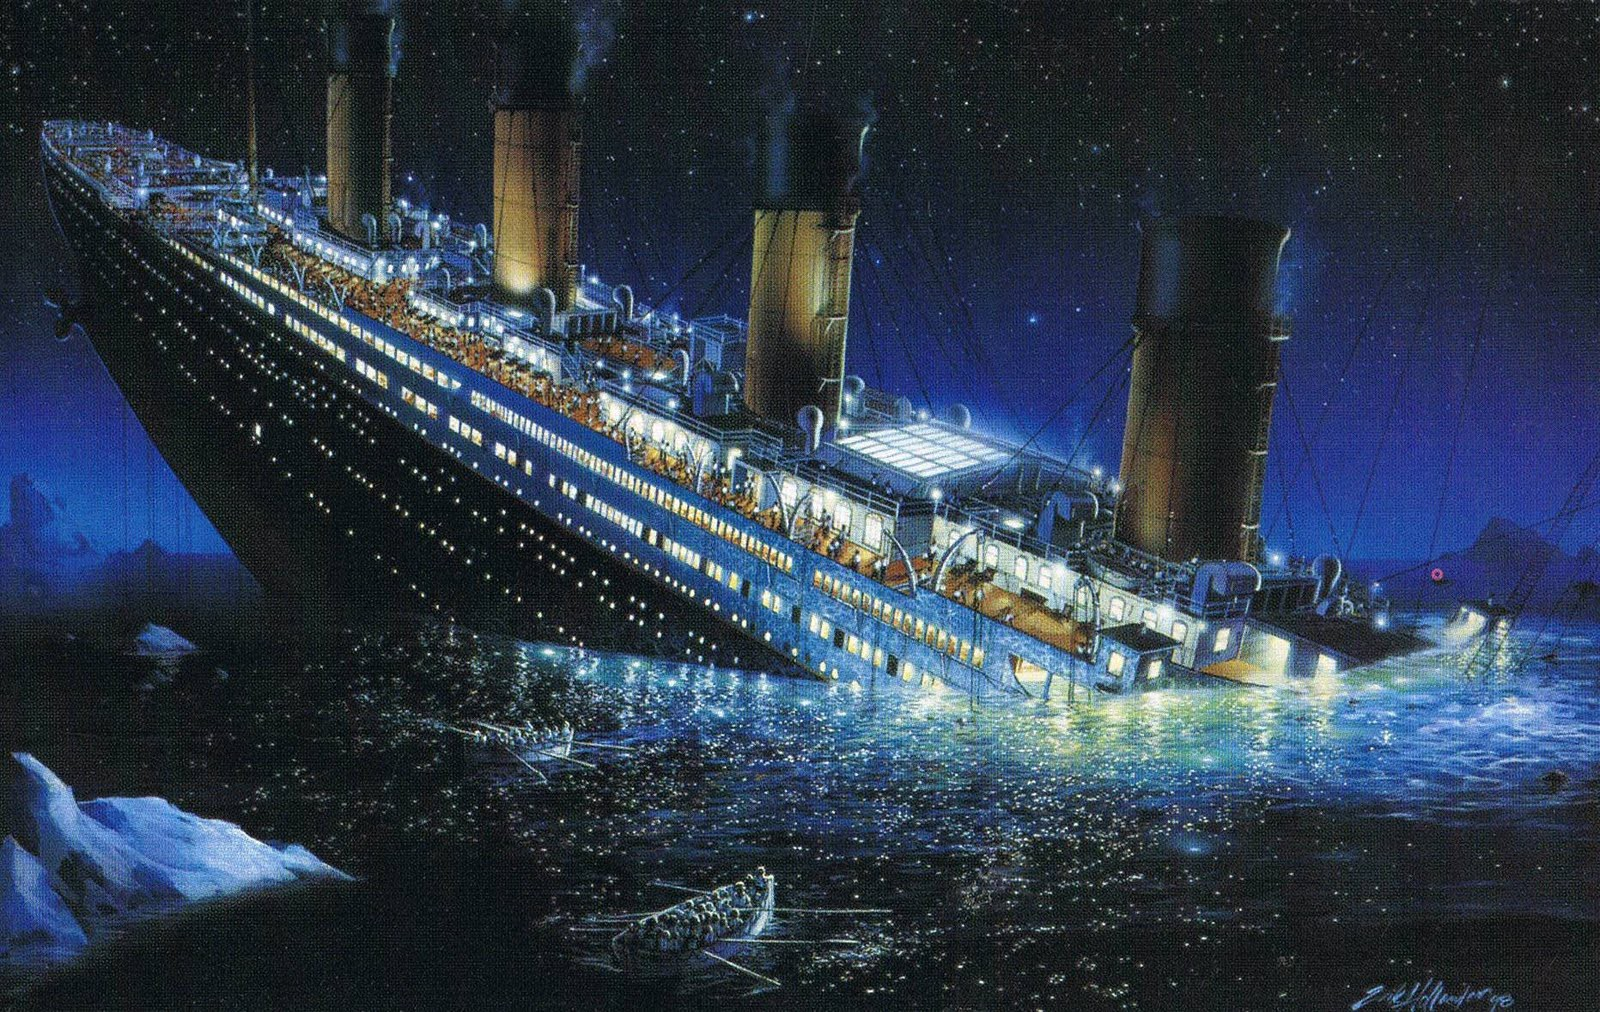

# Introduction
The sinking of the RMS Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this contest, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

This Kaggle Getting Started Competition provides an ideal starting place for people who may not have a lot of experience in data science and machine learning."

<font color = 'blue'>
Content: 

1. [Load and Check Data](#1)
1. [Variable Description](#2)
    * [Univariate Variable Analysis](#3)
        * [Categorical Variable](#4)
        * [Numerical Variable](#5)
1. [Basic Data Analysis](#6)
1. [Outlier Detection](#7)
1. [Missing Value](#8)
    * [Find Missing Value](#9)
    * [Fill Missing Value](#10)
1. [Visualization](#11)
    * [Correlation Between Sibsp -- Parch -- Age -- Fare -- Survived](#12)
    * [SibSp -- Survived](#13)
    * [Parch -- Survived](#14)
    * [Pclass -- Survived](#15)
    * [Age -- Survived](#16)
    * [Pclass -- Survived -- Age](#17)
    * [Embarked -- Sex -- Pclass -- Survived](#18)
    * [Embarked -- Sex -- Fare -- Survived](#19)
    * [Fill Missing: Age Feature](#20)
1. [Feature Engineering](#21)
    * [Name -- Title](#22)
    * [Family Size](#23)
    * [Embarked](#24)
    * [Ticket](#25)
    * [Pclass](#26)
    * [Sex](#27)
    * [Drop Passenger ID and Cabin](#28)
1. [Modeling](#29)
    * [Xgboost,Stacked Ensembels](#30)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

import seaborn as sns

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

<a id = "1"></a><br>
# Load and Check Data 

In [ ]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
test_PassengerId = test_df["PassengerId"]

In [ ]:
train_df.columns

In [ ]:
train_df.head()

In [ ]:
train_df.describe()

<a id = "2"></a><br>
# Variable Description
1. PassengerId: unique id number to each passenger
1. Survived: passenger survive(1) or died(0)
1. Pclass: passenger class
1. Name: name
1. Sex: gender of passenger 
1. Age: age of passenger 
1. SibSp: number of siblings/spouses
1. Parch: number of parents/children 
1. Ticket: ticket number 
1. Fare: amount of money spent on ticket
1. Cabin: cabin category
1. Embarked: port where passenger embarked (C = Cherbourg, Q = Queenstown, S = Southampton)


In [ ]:
train_df.info()

* float64(2): Fare ve Age
* int64(5): Pclass, sibsp, parch, passengerId and survived
* object(5): Cabin, embarked, ticket, name and sex

<a id = "3"></a><br>
# Univariate Variable Analysis
* Categorical Variable: Survived, Sex, Pclass, Embarked, Cabin, Name, Ticket, Sibsp and Parch
* Numerical Variable: Fare, age and passengerId

<a id = "4"></a><br>
## Categorical Variable

In [ ]:
def bar_plot(variable):
    """
        input: variable ex: "Sex"
        output: bar plot & value count
    """
    # get feature
    var = train_df[variable]
    # count number of categorical variable(value/sample)
    varValue = var.value_counts()
    
    # visualize
    plt.figure(figsize = (9,3))
    plt.bar(varValue.index, varValue)
    plt.xticks(varValue.index, varValue.index.values)
    plt.ylabel("Frequency")
    plt.title(variable)
    plt.show()
    print("{}: \n {}".format(variable,varValue))

In [ ]:
category1 = ["Survived","Sex","Pclass","Embarked","SibSp", "Parch"]
for c in category1:
    bar_plot(c)

In [ ]:
category2 = ["Cabin", "Name", "Ticket"]
for c in category2:
    print("{} \n".format(train_df[c].value_counts()))

<a id = "5"></a><br>
## Numerical Variable

In [ ]:
def plot_hist(variable):
    plt.figure(figsize = (9,3))
    plt.hist(train_df[variable], bins = 50)
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title("{} distribution with hist".format(variable))
    plt.show()

In [ ]:
numericVar = ["Fare", "Age","PassengerId"]
for n in numericVar:
    plot_hist(n)

<a id = "6"></a><br>
# Basic Data Analysis
* Pclass - Survived
* Sex - Survived
* SibSp - Survived
* Parch - Survived

In [ ]:
# Plcass vs Survived
train_df[["Pclass","Survived"]].groupby(["Pclass"], as_index = False).mean().sort_values(by="Survived",ascending = False)

In [ ]:
# Sex vs Survived
train_df[["Sex","Survived"]].groupby(["Sex"], as_index = False).mean().sort_values(by="Survived",ascending = False)

In [ ]:
# Sibsp vs Survived
train_df[["SibSp","Survived"]].groupby(["SibSp"], as_index = False).mean().sort_values(by="Survived",ascending = False)

In [ ]:
# Parch vs Survived
train_df[["Parch","Survived"]].groupby(["Parch"], as_index = False).mean().sort_values(by="Survived",ascending = False)

<a id = "7"></a><br>
# Outlier Detection

In [ ]:
def detect_outliers(df,features):
    outlier_indices = []
    
    for c in features:
        # 1st quartile
        Q1 = np.percentile(df[c],25)
        # 3rd quartile
        Q3 = np.percentile(df[c],75)
        # IQR
        IQR = Q3 - Q1
        # Outlier step
        outlier_step = IQR * 1.5
        # detect outlier and their indeces
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        # store indeces
        outlier_indices.extend(outlier_list_col)
    
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2)
    
    return multiple_outliers

In [ ]:
train_df.loc[detect_outliers(train_df,["Age","SibSp","Parch","Fare"])]

In [ ]:
# drop outliers
train_df = train_df.drop(detect_outliers(train_df,["Age","SibSp","Parch","Fare"]),axis = 0).reset_index(drop = True)

<a id = "8"></a><br>
# Missing Value
* Find Missing Value
* Fill Missing Value

In [ ]:
train_df_len = len(train_df)
train_df = pd.concat([train_df,test_df],axis = 0).reset_index(drop = True)

In [ ]:
train_df.head()

<a id = "9"></a><br>
## Find Missing Value

In [ ]:
train_df.columns[train_df.isnull().any()]

In [ ]:
train_df.isnull().sum()

<a id = "10"></a><br>
## Fill Missing Value
* Embarked has 2 missing value
* Fare has only 1

In [ ]:
train_df[train_df["Embarked"].isnull()]

In [ ]:
train_df.boxplot(column="Fare",by = "Embarked")
plt.show()

In [ ]:
train_df["Embarked"] = train_df["Embarked"].fillna("C")
train_df[train_df["Embarked"].isnull()]

In [ ]:
train_df[train_df["Fare"].isnull()]

In [ ]:
train_df["Fare"] = train_df["Fare"].fillna(np.mean(train_df[train_df["Pclass"] == 3]["Fare"]))

In [ ]:
train_df[train_df["Fare"].isnull()]

<a id = "11"></a><br>
# Visualization

<a id = "12"></a><br>
## Correlation Between Sibsp -- Parch -- Age -- Fare -- Survived

In [ ]:
list1 = ["SibSp", "Parch", "Age", "Fare", "Survived"]
sns.heatmap(train_df[list1].corr(), annot = True, fmt = ".2f")
plt.show()

Fare feature seems to have correlation with survived feature (0.26).

<a id = "13"></a><br>
## SibSp -- Survived

In [ ]:
g = sns.factorplot(x = "SibSp", y = "Survived", data = train_df, kind = "bar", size = 6)
g.set_ylabels("Survived Probability")
plt.show()

* Having a lot of SibSp have less chance to survive.
* if sibsp == 0 or 1 or 2, passenger has more chance to survive
* we can consider a new feature describing these categories.

<a id = "14"></a><br>
## Parch -- Survived

In [ ]:
g = sns.factorplot(x = "Parch", y = "Survived", kind = "bar", data = train_df, size = 6)
g.set_ylabels("Survived Probability")
plt.show()

* Sibsp and parch can be used for new feature extraction with th = 3
* small familes have more chance to survive.
* there is a std in survival of passenger with parch = 3

<a id = "15"></a><br>
## Pclass -- Survived

In [ ]:
g = sns.factorplot(x = "Pclass", y = "Survived", data = train_df, kind = "bar", size = 6)
g.set_ylabels("Survived Probability")
plt.show()

<a id = "16"></a><br>
## Age -- Survived

In [ ]:
g = sns.FacetGrid(train_df, col = "Survived")
g.map(sns.distplot, "Age", bins = 25)
plt.show()

* age <= 10 has a high survival rate,
* oldest passengers (80) survived,
* large number of 20 years old did not survive,
* most passengers are in 15-35 age range,
* use age feature in training
* use age distribution for missing value of age

<a id = "17"></a><br>
## Pclass -- Survived -- Age

In [ ]:
g = sns.FacetGrid(train_df, col = "Survived", row = "Pclass", size = 2)
g.map(plt.hist, "Age", bins = 25)
g.add_legend()
plt.show()

* pclass is important feature for model training.

<a id = "18"></a><br>
## Embarked -- Sex -- Pclass -- Survived

In [ ]:
g = sns.FacetGrid(train_df, row = "Embarked", size = 2)
g.map(sns.pointplot, "Pclass","Survived","Sex")
g.add_legend()
plt.show()

* Female passengers have much better survival rate than males.
* males have better survşval rate in pclass 3 in C.
* embarked and sex will be used in training.

<a id = "19"></a><br>
## Embarked -- Sex -- Fare -- Survived

In [ ]:
g = sns.FacetGrid(train_df, row = "Embarked", col = "Survived", size = 2.3)
g.map(sns.barplot, "Sex", "Fare")
g.add_legend()
plt.show()

* Passsengers who pay higher fare have better survival. Fare can be used as categorical for training.

<a id = "20"></a><br>
## Fill Missing: Age Feature

In [ ]:
train_df[train_df["Age"].isnull()]

In [ ]:
sns.factorplot(x = "Sex", y = "Age", data = train_df, kind = "box")
plt.show()

Sex is not informative for age prediction, age distribution seems to be same.

In [ ]:
sns.factorplot(x = "Sex", y = "Age", hue = "Pclass",data = train_df, kind = "box")
plt.show()

1st class passengers are older than 2nd, and 2nd is older than 3rd class. 

In [ ]:
sns.factorplot(x = "Parch", y = "Age", data = train_df, kind = "box")
sns.factorplot(x = "SibSp", y = "Age", data = train_df, kind = "box")
plt.show()

In [ ]:
sns.heatmap(train_df[["Age","Sex","SibSp","Parch","Pclass"]].corr(), annot = True)
plt.show()

Age is not correlated with sex but it is correlated with parch, sibsp and pclass.

In [ ]:
index_nan_age = list(train_df["Age"][train_df["Age"].isnull()].index)
for i in index_nan_age:
    age_pred = train_df["Age"][((train_df["SibSp"] == train_df.iloc[i]["SibSp"]) &(train_df["Parch"] == train_df.iloc[i]["Parch"])& (train_df["Pclass"] == train_df.iloc[i]["Pclass"]))].median()
    age_med = train_df["Age"].median()
    if not np.isnan(age_pred):
        train_df["Age"].iloc[i] = age_pred
    else:
        train_df["Age"].iloc[i] = age_med

In [ ]:
train_df[train_df["Age"].isnull()]

<a id = "21"></a><br>
# Feature Engineering

<a id = "22"></a><br>
## Name -- Title

In [ ]:
train_df["Name"].head(10)

In [ ]:
name = train_df["Name"]
train_df["Title"] = [i.split(".")[0].split(",")[-1].strip() for i in name]

In [ ]:
 train_df["Title"].head(10)

In [ ]:
sns.countplot(x="Title", data = train_df)
plt.xticks(rotation = 60)
plt.show()

In [ ]:
# convert to categorical
train_df["Title"] = train_df["Title"].replace(["Lady","the Countess","Capt","Col","Don","Dr","Major","Rev","Sir","Jonkheer","Dona"],"other")
train_df["Title"] = [0 if i == "Master" else 1 if i == "Miss" or i == "Ms" or i == "Mlle" or i == "Mrs" else 2 if i == "Mr" else 3 for i in train_df["Title"]]
train_df["Title"].head(20)

In [ ]:
sns.countplot(x="Title", data = train_df)
plt.xticks(rotation = 60)
plt.show()

In [ ]:
g = sns.factorplot(x = "Title", y = "Survived", data = train_df, kind = "bar")
g.set_xticklabels(["Master","Mrs","Mr","Other"])
g.set_ylabels("Survival Probability")
plt.show()

In [ ]:
train_df.drop(labels = ["Name"], axis = 1, inplace = True)

In [ ]:
train_df.head()

In [ ]:
train_df = pd.get_dummies(train_df,columns=["Title"])
train_df.head()

<a id = "23"></a><br>
## Family Size

In [ ]:
train_df.head()

In [ ]:
train_df["Fsize"] = train_df["SibSp"] + train_df["Parch"] + 1

In [ ]:
train_df.head()

In [ ]:
g = sns.factorplot(x = "Fsize", y = "Survived", data = train_df, kind = "bar")
g.set_ylabels("Survival")
plt.show()

In [ ]:
train_df["family_size"] = [1 if i < 5 else 0 for i in train_df["Fsize"]]

In [ ]:
train_df.head(10)

In [ ]:
sns.countplot(x = "family_size", data = train_df)
plt.show()

In [ ]:
g = sns.factorplot(x = "family_size", y = "Survived", data = train_df, kind = "bar")
g.set_ylabels("Survival")
plt.show()

Small familes have more chance to survive than large families.

In [ ]:
train_df = pd.get_dummies(train_df, columns= ["family_size"])
train_df.head()

<a id = "24"></a><br>
## Embarked

In [ ]:
train_df["Embarked"].head()

In [ ]:
sns.countplot(x = "Embarked", data = train_df)
plt.show()

In [ ]:
train_df = pd.get_dummies(train_df, columns=["Embarked"])
train_df.head()

<a id = "25"></a><br>
## Ticket

In [ ]:
train_df["Ticket"].head(20)

In [ ]:
a = "A/5. 2151"
a.replace(".","").replace("/","").strip().split(" ")[0]

In [ ]:
tickets = []
for i in list(train_df.Ticket):
    if not i.isdigit():
        tickets.append(i.replace(".","").replace("/","").strip().split(" ")[0])
    else:
        tickets.append("x")
train_df["Ticket"] = tickets

In [ ]:
train_df["Ticket"].head(20)

In [ ]:
train_df.head()

In [ ]:
train_df = pd.get_dummies(train_df, columns= ["Ticket"], prefix = "T")
train_df.head(10)

<a id = "26"></a><br>
## Pclass

In [ ]:
sns.countplot(x = "Pclass", data = train_df)
plt.show()

In [ ]:
train_df["Pclass"] = train_df["Pclass"].astype("category")
train_df = pd.get_dummies(train_df, columns= ["Pclass"])
train_df.head()

<a id = "27"></a><br>
## Sex

In [ ]:
train_df["Sex"] = train_df["Sex"].astype("category")
train_df = pd.get_dummies(train_df, columns=["Sex"])
train_df.head()

<a id = "28"></a><br>
## Drop Passenger ID and Cabin 

In [ ]:
train_df.drop(labels = ["PassengerId", "Cabin"], axis = 1, inplace = True)

In [ ]:
train_df.columns

In [ ]:
train_df.head(10)

<a id = "29"></a><br>
# Modeling

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

<a id = "30"></a><br>
## XgBoost Fine Tuning

**We are now using a XgBoost Classifier with Tuning using GridSearch CV**

In [ ]:
train_df_len

In [ ]:
test = train_df[train_df_len:]
test.drop(labels = ["Survived"],axis = 1, inplace = True)


In [ ]:
test.head()

In [ ]:
train = train_df[:train_df_len]
X_train = train.drop(labels = "Survived", axis = 1)
y_train = train["Survived"]

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
xgb_model = XGBClassifier(
        objective = 'binary:logistic',
        colsample_bytree = 0.8,
        learning_rate = 0.3,
        max_depth = 7,
        min_child_weight = 3,
        n_estimators = 100,
        subsample = 0.6)

# {'colsample_bytree': 0.5,
#  'learning_rate': 0.1,
#  'max_depth': 7,
#  'min_child_weight': 3,
#  'n_estimators': 100,
#  'objective': 'binary:logistic',
#  'subsample': 0.7}

%time xgb_model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_train, y_train)], verbose=False)
y_pred_xgb = xgb_model.predict(X_train)
a_xgb = accuracy_score(y_train, y_pred_xgb)

print("AS: ", a_xgb)

### K-Folds Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator=xgb_model,X=X_train,y=y_train,cv=5)
print("Accuracy: {:.2f}%".format(accuracies.mean()*100))

## Fine Tuning the Xgb Model

In [ ]:
#XGBoost hyper-parameter tuning
#from sklearn.metrics import mean_squared_error
#from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
def hyperParameterTuning(x_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['binary:logistic']
    }

    xgb_model = XGBClassifier()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [ ]:
hyperParameterTuning(X_train, y_train)

## Stacked Ensembles 

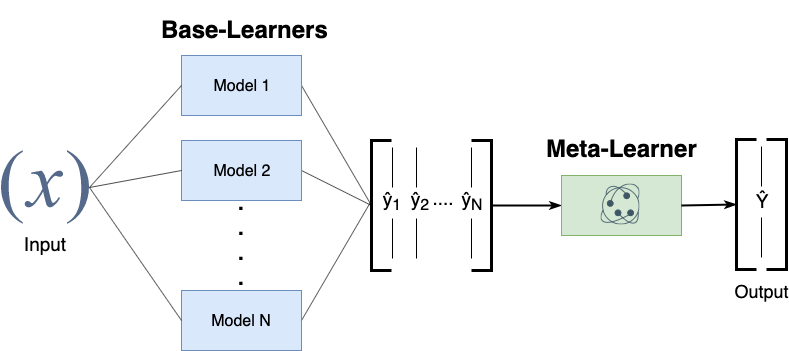

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingRegressor,StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
layer_one_estimators = [
                        ('rf_1', RandomForestClassifier(n_estimators=40, random_state=42)),
                        ('knn_1', KNeighborsClassifier(n_neighbors=6))             
                       ]
layer_two_estimators = [
                        ('rf_2', RandomForestClassifier(n_estimators=40, random_state=42)),
                        #('rf_2', RandomForestRegressor(n_estimators=20, random_state=42)),
                        ('xg_2', XGBClassifier(
        objective = 'binary:logistic',
        colsample_bytree = 0.8,
        learning_rate = 0.3,
        max_depth = 7,
        min_child_weight = 3,
        n_estimators = 100,
        subsample = 0.6)
)

                       ]
layer_two = StackingClassifier(estimators=layer_two_estimators, final_estimator=RandomForestClassifier())

# Create Final model by 
clf2 = StackingClassifier(estimators=layer_one_estimators, final_estimator=layer_two)

In [ ]:
clf2.fit(X_train,y_train)
y_pred_xgb = clf2.predict(X_train)
ac_xgb = accuracy_score(y_train, y_pred_xgb)

print("MAE: ", ac_xgb)

### Generate titanic.csv

In [ ]:
test_survived = pd.Series(xgb_model.predict(test), name = "Survived").astype(int)
results = pd.concat([test_PassengerId, test_survived],axis = 1)
results.to_csv("titanic.csv", index = False)

## Congrats you have made your first Submission 🎉🎊

### Reference's

1. EDA - https://www.kaggle.com/kanncaa1/dataiteam-titanic-eda

<font size="+3" color=orange ><b> <center><u>Upvote If you like it!!👍😁</u></center></b></font>